# TP1 : First order methods on regression models

#### Authors: S. Gaiffas, A. Gramfort

The aim of this material is to derive proximity operators for common regularizations:

- L1
- Group-L1 

and to use them in first order optimization algorithms for regression. The focus is on Ista / Fista for this notebook.

This work **must be done by pairs of students**. One document for each pair of students should be sent to: <alexandre.gramfort@telecom-paristech.fr>

**IMPORTANT**:
- use as object/title for your email **"TP1-DS-Optim"**
- the filename of the notebook **must be name1_name2.ipynb** (where name1 and name2 are the names of the students)

In [3]:
# to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

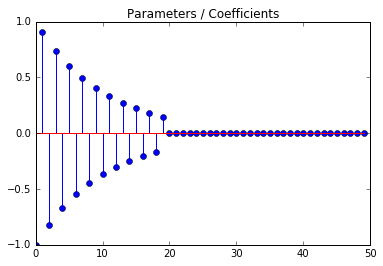

In [7]:
n_features = 50
n_samples = 2000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")
plt.show()

In [8]:
# Simulation of the features matrix
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz

# Correlation
rho = 0.7

# Construction of a covariance matrix
cov = toeplitz(rho ** np.arange(0, n_features))

In [13]:
# Simulation of Gaussian vectors with this covariance matrix (it will be the features)
A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)

In [17]:
A.shape

(2000, 50)

In [18]:
from numpy.random import randn

# Simulation of a linear model
std = 1.
noise = std * randn(n_samples)

# Simulation of the labels according to the linear regression model : b = A coefs + noise
b = A.dot(coefs) + noise

## Questions

- Visualize the covariance of the features. You can use plt.matshow.
- What is the influence of the rho parameter? Can you quantify it using the condition number of the generated matrix X? Use the `scipy.linalg.svd` function to extract the singular values of X.

In [60]:
def viz(rho):

    # Construction of a covariance matrix
    cov = toeplitz(rho ** np.arange(0, n_features))
    
    # Simulation of Gaussian vectors with this covariance matrix (it will be the features)
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    
    # Simulation of a linear model
    std = 1.
    noise = std * randn(n_samples)

    # Simulation of the labels according to the linear regression model : b = A coefs + noise
    b = A.dot(coefs) + noise

    plt.matshow(cov)

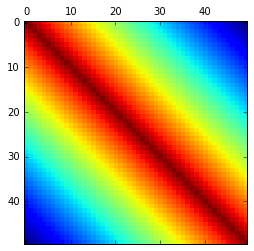

In [69]:
viz(0.99)

In [44]:
from scipy.linalg import svd
svd(cov)[2].mean()

-0.0027270964337779047

## Part 1 : Proximal operators

We remind that the proximal operator of the L1 norm used by the Lasso is defined by:

$$
\text{prox}(y) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + \lambda_1 \|x\|_1 \Big\}.
$$

It is given by the soft-thresholding operator:

$$
\text{prox}(y) = \text{sign}(y) \odot (|y| - \lambda_1)_+.
$$

In [61]:
def prox_lasso(x, l_l1):
    """Proximal operator for the L1 norm / Lasso at x"""
    x_abs = np.abs(x)
    return np.sign(x) * np.maximum(x_abs - l_l1, 0)

def lasso(x, l_l1):
    """Value of the Lasso penalization at x"""
    return l_l1 * np.abs(x).sum()

In [97]:
def prox_ridge(x, l_l2):
    """Proximal operator for the L1 norm / Lasso at x"""
    aux = max(0, 1-(l_l2/((x**2).sum())))
    return aux*x

def ridge(x, l_l2):
    """Value of the Lasso penalization at x"""
    return (l_l2/2) * (x**2).sum()

In [99]:
prox_ridge(randn(10), 1)

array([ 0.28,  0.45, -1.24, -0.53,  1.59,  0.01,  0.53, -0.99, -0.47,  1.7 ])

The proximal operator for the Elastic-Net is defined by:

$$
\text{prox}(y) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + \lambda_1 \|x\|_1 + \frac{\lambda_2}{2} \|x\|_2^2 \Big\}
$$

## Questions

- Implement the proximal operator of the Elastic-Net
- Visualize the functions applied element wise by the proximity operators of the Lasso (so called soft-thresholding function) and the Elastic-Net

In [103]:
from numpy.linalg import norm

def prox_enet(x, l_l1, l_l2):
    """Proximal operator for the elastic net at x"""
    if l_l1 == 0:
        return prox_ridge(x, l_l2)
    elif l_l2 == 0:
        return prox_lasso(x, l_l1)
    else:
        return  (1/l_l2)*prox_lasso(x, l_l1)

def enet(x, l_l1, l_l2):
    """Value of the Elastic-net penalization at x"""
    return lasso(x, l_l1) + (x**2).sum()*l_l2/2

In [104]:
x = randn(50)

In [105]:
prox_enet(x, 0, 2)

array([ -6.88e-01,   2.50e-01,   6.61e-01,   1.23e+00,   3.64e-02,
        -9.72e-01,   1.27e-01,   3.36e-01,  -1.39e-01,  -1.12e+00,
         9.19e-01,   1.37e+00,  -9.49e-01,   1.96e+00,  -1.83e-01,
         1.03e-01,  -1.36e+00,   3.84e-01,   3.01e-01,  -2.13e-01,
        -3.09e-01,  -9.12e-01,  -6.14e-01,  -2.11e+00,   4.52e-01,
         7.19e-01,  -5.29e-01,  -8.60e-02,  -1.75e-02,  -2.64e-01,
        -2.19e+00,   5.97e-01,  -2.88e-01,   2.55e-01,  -3.16e-01,
         3.62e-01,  -5.07e-01,   4.47e-01,   7.28e-01,   1.07e+00,
         2.77e-01,   1.52e+00,   1.21e+00,  -4.82e-01,  -1.57e+00,
        -7.45e-02,  -4.34e-01,  -1.71e+00,  -1.51e+00,  -8.02e-04])

In [106]:
enet(np.array([1, 2, 3]), 1, 1)

13.0

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

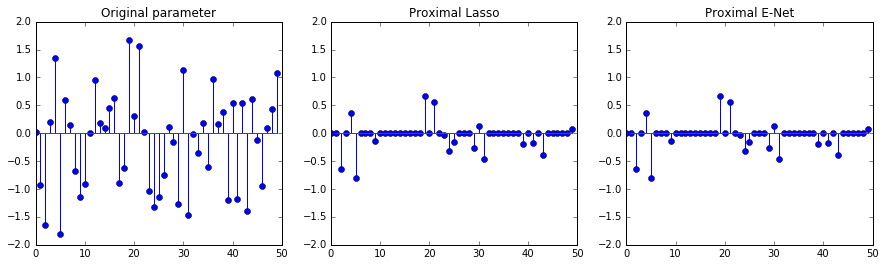

In [113]:
x = randn(50)
l_l1 = 1
l_l2 = 0

plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter")
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, l_l1=l_l1))
plt.title("Proximal Lasso")
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_enet(x, l_l1=l_l1, l_l2=l_l2))
plt.title("Proximal E-Net")
plt.ylim([-2, 2])

## Question

- Comment what you observe (3 sentences max).

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below penalized linear regression problems, namely

$$
f(x) = \frac{1}{2 n} \| b - A x \|^2
$$

where $n$ is the sample size.

We therefore need to be able to compute $f$ and its gradient

**Questions**:
- Code a function that computes the gradient of f
- Check that this function is correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``

In [147]:
# TO BE COMPLETED

# Least-squares loss
def f(x):
    return 0.5 * norm(b - A.dot(x)) ** 2 / n_samples

def grad_f(x):
    return (b - A.dot(x)) / n_samples # TODO

from scipy.optimize import check_grad

x = np.random.randn(n_features)

print(check_grad(f, grad_f, x)) # This should be a very small number

ValueError: operands could not be broadcast together with shapes (2000,) (50,) 

In [145]:
grad_f(x).shape, x.shape

((2000,), (50,))

## Part 3: Solvers

We know have a function to compute $f$ and $g$ and their gradients. We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:
- Implement ISTA algorithm for the Elastic-Net.

- Implement FISTA algorithm for the Elastic-Net.

Remark: The `step` parameter will be taken as 1 / L

In [149]:
ista(randn(10, 1, 1, step = 1))

NameError: name 'ista' is not defined

In [156]:
"obj".center(8)

'  obj   '

In [159]:
# TO BE COMPLETED

def ista(x0, l_l1=0., l_l2=0., step=None, n_iter=50, x_true=coefs):
    x = x0.copy()
    x_new = x0.copy()
    
    def g(x):
        return enet(x, l_l1, l_l2) # TODO

    def prox_g(x, t):
        x = x - t*grad_f(x)
        return  prox_lasso(x, t) # TODO    
    
    if step is None:
        step = 0  # TODO

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x)
    objectives.append(obj)    
    print("Lauching ISTA solver...")
    #print' | '.join([name.center(8) for name in ["it", "obj", "err"]])
    for k in range(n_iter):
        # ISTA update
        x_new[:] = prox_g(x, step)  # TODO
        x[:] = x_new  # TODO
        obj = f(x) + g(x)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0:
            pass
            #print ' | '.join( [ ("%d" % k).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)])
    return x, objectives, errors

In [161]:
ista(np.zeros(n_features), step = 1)

Lauching ISTA solver...


ValueError: operands could not be broadcast together with shapes (50,) (2000,) 

In [15]:
# TO BE COMPLETED

def fista(x0, l_l1=0., l_l2=0., step=None, n_iter=50, x_true=coefs):
    x = x0.copy()
    x_new = x0.copy()

    # TODO
    return x, objectives, errors

Let's launch the algorithms in order to compare them

In [18]:
x0 = np.zeros(n_features)
n_iter = 40
l_l1 = 5e-2
l_l2 = 1e-1
x_ista, obj_ista, err_ista = ista(x0, l_l1, l_l2, n_iter=n_iter)
x_fista, obj_fista, err_fista = fista(x0, l_l1, l_l2, n_iter=n_iter)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.05e+00 | 9.69e-01
      10 | 9.35e-01 | 8.26e-01
      20 | 9.15e-01 | 7.53e-01
      30 | 9.08e-01 | 7.11e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.05e+00 | 9.69e-01
      10 | 9.19e-01 | 7.72e-01
      20 | 9.05e-01 | 6.73e-01
      30 | 9.05e-01 | 6.50e-01


### Algorithms comparison

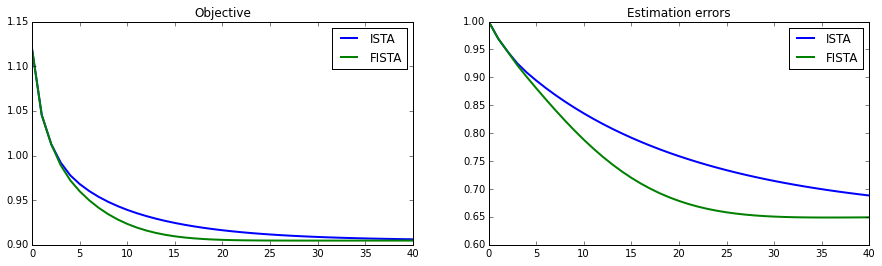

In [19]:
plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 2, 1)
plt.plot(obj_ista, label="ISTA", lw=2)
plt.plot(obj_fista, label="FISTA", lw=2)
plt.title("Objective")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(err_ista, label="ISTA", lw=2)
plt.plot(err_fista, label="FISTA", lw=2)
plt.legend()
plt.title("Estimation errors")

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.04e+00 | 9.67e-01
      10 | 8.91e-01 | 7.82e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.04e+00 | 9.67e-01
      10 | 8.64e-01 | 7.10e-01


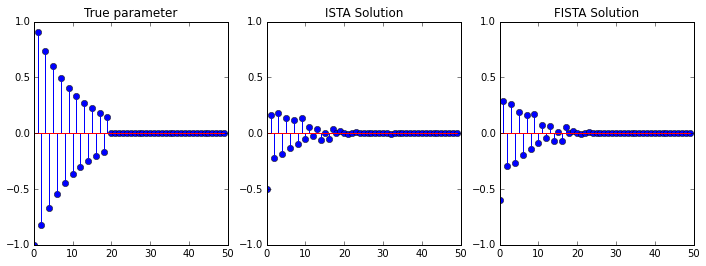

In [20]:
# Let's reduce the number of iterations and compare estimators
n_iter = 15
l_l1 = 3e-2
l_l2 = 1e-1

x_ista, obj_ista, err_ista = ista(x0, l_l1, l_l2, n_iter=n_iter)
x_fista, obj_fista, err_fista = fista(x0, l_l1, l_l2, n_iter=n_iter)

# Estimated parameters using ISTA, FISTA and Coordinate Descent
plt.rcParams['figure.figsize'] = (16.0, 4.0)
plt.subplot(1, 4, 1)
plt.stem(coefs)
plt.ylim([-1, 1])
plt.title("True parameter")
plt.subplot(1, 4, 2)
plt.stem(x_ista)
plt.ylim([-1, 1])
plt.title("ISTA Solution")
plt.subplot(1, 4, 3)
plt.stem(x_fista)
plt.ylim([-1, 1])
plt.title("FISTA Solution")

### Questions

- Relaunch solvers with several values of rho (rho = 0.9, rho = 0.1). How does rho affect the convergence? Why?

## Part 4. Multitask learning

We consider the setting of multitask learning, where instead of a single label $b_i$ we have ``n_tasks`` labels. The model writes

$$
B = A C + E
$$

where:
- $B$ is a (``n_samples``, ``n_tasks``) labels matrix
- $A$ is a (``n_samples``, ``n_features``) features matrix
- $C$ is a (``n_features``, ``n_tasks``) matrix of parameters to be estimated
- $E$ is a (``n_samples``, ``n_tasks``) noise matrix

Let's simulate this model:

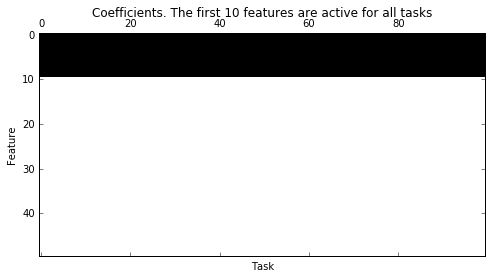

In [50]:
from numpy.random import randn
from matplotlib.cm import Greys

n_features = 50
n_samples = 2000
n_tasks = 100

std = 5.
noise = std * randn(n_samples, n_tasks)

coefs = np.zeros((n_features, n_tasks))
coefs[0:10, :] = 1.

B = A.dot(coefs) + noise

plt.matshow(coefs, cmap=Greys)
plt.title("Coefficients. The first 10 features are active for all tasks")
plt.xlabel("Task")
plt.ylabel("Feature")

**Questions:**

- Code the Lasso for the multitask problem using Fista (most of the previous code could be used as such)
- Plot the coefficients obtained 

In [51]:
# TO BE COMPLETED

# Multitask least-squares loss
def f(x):
    return 0.5 * norm(B - A.dot(x)) ** 2 / (n_samples * n_tasks)

def grad_f(x):
    return x # TODO

x0 = np.random.randn(n_features, n_tasks)
n_iter = 50
l_l1 = 0.5
l_l2 = 0.
x_fista, obj_fista, err_fista = fista(x0, l_l1, l_l2, n_iter=n_iter, x_true=coefs)

NameError: name 'fista' is not defined

### Solution of the Lasso for the multitask problem

In [52]:
plt.matshow(x_lasso, cmap=Greys)
plt.title("Recovered coefficients.")
plt.xlabel("Task")
plt.ylabel("Feature")

NameError: name 'x_lasso' is not defined

### Group-Lasso for the multitask problem

We want now to use group Lasso for the multitask problem. 
We consider then the Group-Lasso penalization, with proximal operator given by

$$
\text{prox}(Y) = \arg\min_X \Big\{ \frac 12 \|X - Y\|_F^2 + \lambda_{2, 1} \|X\|_{2, 1} \Big\},
$$

where

- $\|X\|_F$ is the Frobenius norm (matrix Euclidean norm)
- $\|X\|_{2, 1} = \sum_{j=1}^d \sqrt{\sum_{k=1}^K X_{j, k}^2}$ with $d$ being the number of features and $K$ the number of tasks

**Questions**

- Code the proximal operator of the Group-Lasso
- Based on the previous Fista solver, code a solver for the group-Lasso
- Launch the solver, comment and compare with the Lasso solution

In [25]:
# TO BE COMPLETED

def group_lasso(X, l_group_l1):
    return l_group_l1 * np.sqrt((coefs ** 2).sum(axis=1)).sum()

def prox_group_lasso(X, l_group_l1):
    return x # TODO

def fista_group_lasso(x0, l_group_l1=1., step=None, n_iter=50, x_true=coefs):
    x = x0.copy()
    x_new = x0.copy()
    z = x0.copy()
    n_samples, n_features = A.shape

    def g(x):
        return 0. # TODO

    def prox_g(x, t):
        return x # TODO
    
    if step is None:
        step = 1. / norm(gram_matrix, 2)

    errors = []
    objectives = []
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    obj = f(x) + g(x)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    print "Lauching FISTA solver..."    
    print ' | '.join([name.center(8) for name in ["it", "obj", "err"]])
    for k in range(n_iter):
        x_new[:] = prox_g(z - step * grad_f(z), step)
        t_new = (1. + (1. + 4. * t * t)) ** (0.5) / 2.
        z[:] = x_new + (t - 1) / t_new * (x_new - x)
        t = t_new
        x[:] = x_new
        obj = f(x) + g(x)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0:
            print ' | '.join( [ ("%d" % k).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)])
    return x, objectives, errors

In [27]:
x0 = np.random.randn(n_features, n_tasks)
n_iter = 50
l_group_l1 = 5.
x_glasso, _, _ = fista_group_lasso(x0, l_group_l1, n_iter=n_iter, x_true=coefs)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.21e+02 | 1.75e+00
      10 | 5.13e+02 | 1.87e-01
      20 | 5.13e+02 | 1.76e-01
      30 | 5.13e+02 | 1.78e-01
      40 | 5.13e+02 | 1.79e-01


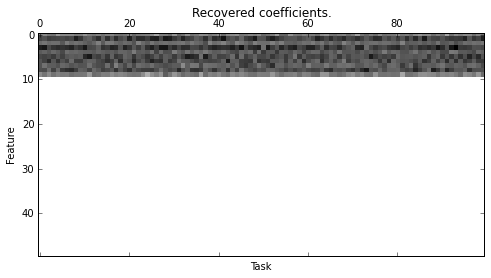

In [28]:
plt.matshow(x_glasso, cmap=Greys)
plt.title("Recovered coefficients.")
plt.xlabel("Task")
plt.ylabel("Feature")

** Extra questions**
- Code gradient and likelihood of the logistic regression model. Use ISTA and FISTA to solve penalized logistic regression
- Implement a backtracking linesearch in ISTA and FISTA (and increase the step at each iteration to accelerate)